In [28]:
# =========================
# CUSTOMER SEGMENTATION PROJECT 
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# -------------------------
# 1. Load the dataset
# -------------------------
file_path = "/Users/macbookair/Desktop/Codes/Data Analytics proj/online_retail_II.xlsx"
df = pd.read_excel(file_path)

print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (525461, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [29]:
# -------------------------
# Check basic info
# -------------------------
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


,Quantity,Price,Customer ID
count,525461.000000,525461.000000,417534.000000
mean,10.337667,4.688834,15360.645478
std,107.424110,146.126914,1680.811316
min,-9600.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,13983.000000
50%,3.000000,2.100000,15311.000000
75%,10.000000,4.210000,16799.000000
max,19152.000000,25111.090000,18287.000000


In [30]:
# -------------------------
# Data Cleaning
# -------------------------

# Rename columns if needed (sometimes spaces vary)
df.columns = df.columns.str.strip()

# Drop rows with missing Customer ID
df = df.dropna(subset=["Customer ID"])

# Remove cancelled orders (Invoices starting with 'C')
df = df[~df["Invoice"].astype(str).str.startswith("C")]

# Remove negative or zero quantities
df = df[df["Quantity"] > 0]

# Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Create TotalAmount column
df["TotalAmount"] = df["Quantity"] * df["Price"]

print("Cleaned data shape:", df.shape)
df.head()


Cleaned data shape: (407695, 9)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [31]:
# -------------------------
#  Create RFM Table
# -------------------------

# Reference date (1 day after last transaction)
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "Invoice": "nunique",
    "TotalAmount": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]

rfm.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,165,11,372.86
12347.0,3,2,1323.32
12348.0,74,1,222.16
12349.0,43,3,2671.14
12351.0,11,1,300.93


In [32]:
# -------------------------
#  RFM Scoring
# -------------------------
rfm["R_Score"] = pd.qcut(rfm["Recency"].rank(method="first"), 4, labels=[4,3,2,1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1,2,3,4])
rfm["M_Score"] = pd.qcut(rfm["Monetary"].rank(method="first"), 4, labels=[1,2,3,4])



In [33]:
# Make sure score columns exist
rfm["R_Score"] = rfm["R_Score"].astype(str)
rfm["F_Score"] = rfm["F_Score"].astype(str)
rfm["M_Score"] = rfm["M_Score"].astype(str)

# Create RFM_Score column
rfm["RFM_Score"] = rfm["R_Score"] + rfm["F_Score"] + rfm["M_Score"]

# Verify
rfm[["R_Score", "F_Score", "M_Score", "RFM_Score"]].head()


,R_Score,F_Score,M_Score,RFM_Score
Customer ID,,,,
12346.0,1,4,2,142
12347.0,4,2,3,423
12348.0,2,1,1,211
12349.0,3,3,4,334
12351.0,4,1,1,411


In [34]:
print(rfm.columns)


Index(['Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score',
       'RFM_Score'],
      dtype='object')


In [35]:
# -------------------------
#  Segment Mapping
# -------------------------

def segment_customer(rfm_score):
    if rfm_score in ["444","443","434","433"]:
        return "Champions"
    elif rfm_score in ["344","343","334","333"]:
        return "Loyal Customers"
    elif rfm_score in ["144","143","244","243"]:
        return "At Risk"
    elif rfm_score in ["411","412","421"]:
        return "New Customers"
    elif rfm_score == "111":
        return "Lost"
    else:
        return "Others"

rfm["Segment"] = rfm["RFM_Score"].apply(segment_customer)
rfm["Segment"].value_counts()



Others             2379
Champions           762
Loyal Customers     512
Lost                343
At Risk             198
New Customers       120
Name: Segment, dtype: int64

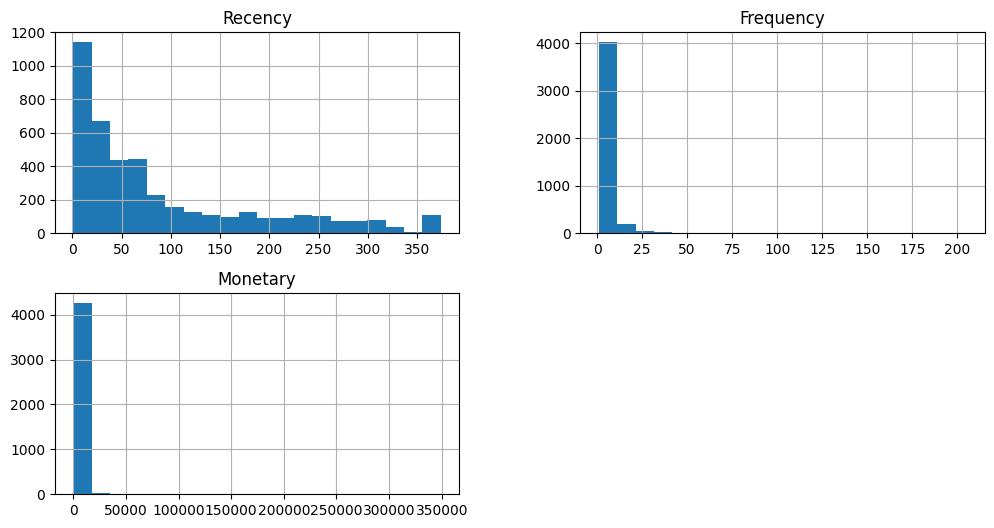

In [36]:
# -------------------------
# Visualization (RFM distribution)
# -------------------------
rfm[["Recency","Frequency","Monetary"]].hist(bins=20, figsize=(12,6))
plt.show()


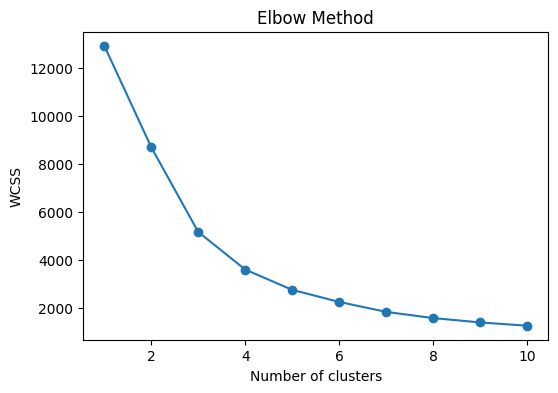

In [37]:
# -------------------------
#  K-Means Clustering
# -------------------------

# Scale RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[["Recency","Frequency","Monetary"]])

# Elbow Method to find best K
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(1,11), wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()


In [38]:
# Apply KMeans with chosen K (usually 4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,Cluster
Customer ID,,,,,,,,,
12346.0,165,11,372.86,1,4,2,142,Others,2
12347.0,3,2,1323.32,4,2,3,423,Others,0
12348.0,74,1,222.16,2,1,1,211,Others,0
12349.0,43,3,2671.14,3,3,4,334,Loyal Customers,0
12351.0,11,1,300.93,4,1,1,411,New Customers,0


In [39]:
# -------------------------
# Analyze Clusters
# -------------------------
cluster_summary = rfm.groupby("Cluster").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": "mean",
    "Cluster": "count"
})

cluster_summary.rename(columns={"Cluster":"Count"}, inplace=True)
cluster_summary


,Recency,Frequency,Monetary,Count
Cluster,,,,
0,43.031835,4.455056,1719.021641,3204
1,5.600000,113.600000,215543.670000,5
2,243.086749,1.658723,595.746486,1049
3,14.910714,47.017857,28957.170054,56
